<!-- ---------------------------------------------------- -->
  <div class="col-sm-3 col-md-3 col-lg-3">
	<!-- logo -->  
    <div class="img-responsive">
      <img src="https://www.dropbox.com/s/220ncn0o5danuey/pandas-ipython-tutorials-hedaro.jpg?dl=1" title="Pandas Tutorial | Hedaro" alt="Pandas Tutorial | Hedaro">    
    </div>
	<!-- logo -->	
  </div>
<!-- ---------------------------------------------------- --> 
  <div class="col-sm-6 col-md-6 col-lg-6">
	<!-- Pandas Tutorial -->  
	  <center>
	    <br>
        <h1>Data Analysis - Triple Exponential Smoothing</h1>
        <p>Learn how to use Pandas and Statmodels to perform Triple <strong>Exponential Smoothing</strong> on time series data</p>
	  </center>	
    <!-- Pandas Tutorial -->	
  </div>
<!-- ---------------------------------------------------- -->

In [1]:
# pandas imports
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

# statsmodels imports
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib as mpl # only needed to get version
%matplotlib inline

In [2]:
print('pandas version: ' + pd.__version__)
print('pandas version: ' + sm.version.version)
print('matplotlib version: ' + mpl.__version__)

pandas version: 0.22.0
pandas version: 0.9.0rc1
matplotlib version: 1.5.1


# Resources Used

* [Statsmodels Notebook- not rendered](https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/exponential_smoothing.ipynb)

* [Statsmodels Notebook- rendered](https://github.com/tvanzyl/statsmodels/blob/881588c33899554ccd8df0da59be8cf806c8b973/examples/notebooks/exponential_smoothing.ipynb) - This notebook was the starting point for this tutorial.

* [Time Series Book](https://www.otexts.org/fpp/7) - Note that some of the text in this tutorial was copied exactly from this book. In certain sections I paraphrased the text from the book to make it easier to understand. 

# Definitions  

* The ***[SSE](https://en.wikipedia.org/wiki/Residual_sum_of_squares)*** is the sum of the squared errors  
* A ***trend*** exists when there is a long-term increase or decrease in the data.    
* A ***seasonal*** pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week.
* A ***cycle*** occurs when the data exhibit rises and falls that are not of a fixed period.

# Data Sets  

> These data sets come from the Time Series book in the Resources section. Note that the Statsmodels notebook is where I got the data sets from  

***important*** - Notice that the date index was given a frequency. The reason for this is that the exponential smoothing functions require your date index to have a frequency. This becomes important when you try to use your own data as frequency might not be something you normally set on your date columns.

In [3]:
data = [446.6565,  454.4733,  455.663 ,  423.6322,  456.2713,  440.5881, 425.3325,  485.1494,  506.0482,  526.792 ,  514.2689,  494.211 ]
index= pd.DatetimeIndex(start='1996', end='2008', freq='A')
oildata = pd.DataFrame(data, columns=['Sales'])
oildata.set_index(index, inplace=True)

data = [17.5534,  21.86  ,  23.8866,  26.9293,  26.8885,  28.8314, 30.0751,  30.9535,  30.1857,  31.5797,  32.5776,  33.4774, 39.0216,  41.3864,  41.5966]
index= pd.DatetimeIndex(start='1990', end='2005', freq='A')
air = pd.DataFrame(data, columns=['Sales'])
air.set_index(index, inplace=True)

data = [263.9177,  268.3072,  260.6626,  266.6394,  277.5158,  283.834 , 290.309 ,  292.4742,  300.8307,  309.2867,  318.3311,  329.3724, 338.884 ,  339.2441,  328.6006,  314.2554,  314.4597,  321.4138, 329.7893,  346.3852,  352.2979,  348.3705,  417.5629,  417.1236, 417.7495,  412.2339,  411.9468,  394.6971,  401.4993,  408.2705, 414.2428]
index= pd.DatetimeIndex(start='1970', end='2001', freq='A')
livestock2 = pd.DataFrame(data, columns=['Sales'])
livestock2.set_index(index, inplace=True)

data = [407.9979 ,  403.4608,  413.8249,  428.105 ,  445.3387,  452.9942, 455.7402]
index= pd.DatetimeIndex(start='2001', end='2008', freq='A')
livestock3 = pd.DataFrame(data, columns=['Sales'])
livestock3.set_index(index, inplace=True)

data = [41.7275,  24.0418,  32.3281,  37.3287,  46.2132,  29.3463, 36.4829,  42.9777,  48.9015,  31.1802,  37.7179,  40.4202, 51.2069,  31.8872,  40.9783,  43.7725,  55.5586,  33.8509, 42.0764,  45.6423,  59.7668,  35.1919,  44.3197,  47.9137]
index= pd.DatetimeIndex(start='2005-02', periods=24, freq='QS-MAR')
aust = pd.DataFrame(data, columns=['Sales'])
aust.set_index(index, inplace=True)

# Theory

### Triple Exponential Smoothing
<br>  
* 0 ≤ α ≤ 1  is the smoothing parameter for the level  
* The weights attached to the observations decrease exponentially as we go back in time, hence the name “exponential smoothing”
* If α is small (i.e., close to 0), more weight is given to observations from the more distant past  
* If α is large (i.e., close to 1), more weight is given to the more recent observations    
<br>  
* 0 ≤ β ≤ 1  is the smoothing parameter for the trend  
* β controls the learning speed of the trend  
<br>  
* 0 ≤ γ ≤ 1  is the smoothing parameter for the seasonal component   

# aust  

> please go to https://www.otexts.org/fpp/7/5

In [4]:
aust

Sales
2005-03-01  41.7275
2005-06-01  24.0418
2005-09-01  32.3281
2005-12-01  37.3287
2006-03-01  46.2132
2006-06-01  29.3463
2006-09-01  36.4829
2006-12-01  42.9777
2007-03-01  48.9015
2007-06-01  31.1802
2007-09-01  37.7179
2007-12-01  40.4202
2008-03-01  51.2069
2008-06-01  31.8872
2008-09-01  40.9783
2008-12-01  43.7725
2009-03-01  55.5586
2009-06-01  33.8509
2009-09-01  42.0764
2009-12-01  45.6423
2010-03-01  59.7668
2010-06-01  35.1919
2010-09-01  44.3197
2010-12-01  47.9137

> ***Notice the Freq is set.*** I'm bringing it up again since the exponential smoothing functions did not work on my dataframe that did not have Freq set.

In [5]:
# QS-MAR = quarter monthls start on the first of the month, year ends in March
aust.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2005-03-01 to 2010-12-01
Freq: QS-MAR
Data columns (total 1 columns):
Sales    24 non-null float64
dtypes: float64(1)
memory usage: 384.0 bytes


We can see that there seems to be a seasonality component and the data is trending upward.

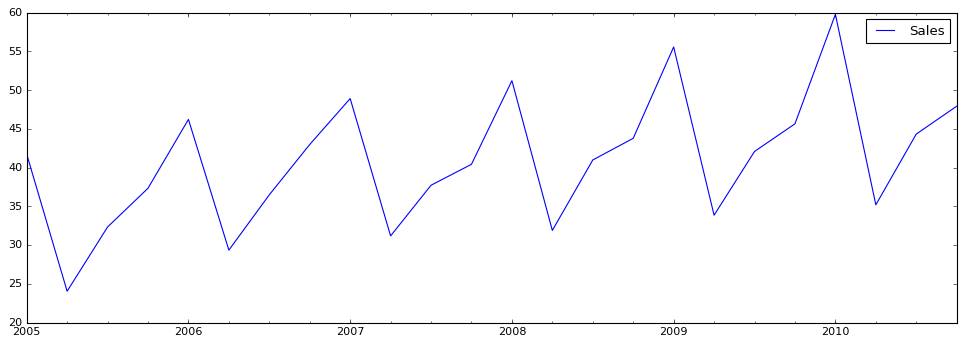

In [6]:
aust.plot(figsize=(15,5));

Let's continue our Exploratory Analysis of our data. [resource](https://www.itl.nist.gov/div898/handbook/eda/section3/4plot.htm)

1. Run sequence plot (top left) to test fixed location and variation.  

2. Lag Plot (top right) to test randomness.

3. Histogram (bottom left) to test (normal) distribution.  

4. Normal probability plot (bottom right) to test normal distribution.  

Of the 4 underlying assumptions:  
* If the fixed location assumption holds, then the run sequence plot will be flat and non-drifting.
* If the fixed variation assumption holds, then the vertical spread in the run sequence plot will be approximately the same over the entire horizontal axis.
* If the randomness assumption holds, then the lag plot will be structure less and random.
* If the fixed distribution assumption holds (in particular, if the fixed normal distribution assumption holds), then the histogram will be bell-shaped and the normal probability plot will be approximately linear.  
* When the randomness assumption is thus seriously violated, the histogram (lower left) and normal probability plot (lower right) are ignored since determining the distribution of the data is only meaningful when the data are random.

***Conclusions*** - Since we are working with Time Series data, I use the run sequence to look for trends and seasonality. We already covered this from our last chart. The lag plot tells me that there seems to be a significant correlation for lag 1 but it looks to be seperated into two populations. The histogram and the probability distribution tell me that we are not working with a normally distributed data set. Although it is not too far off.

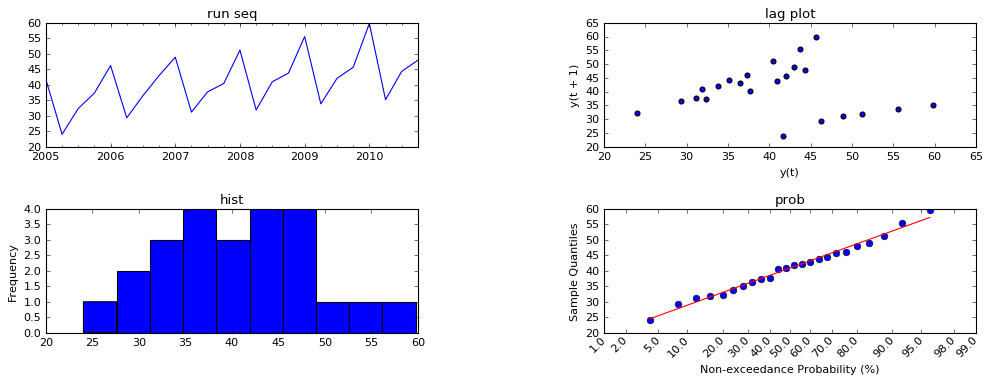

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.5, hspace=0.5);

aust['Sales'].plot(ax=axes[0,0], figsize=(15,5)); axes[0,0].set_title('run seq');
lag_plot(aust['Sales'], ax=axes[0,1]); axes[0,1].set_title('lag plot');
aust['Sales'].plot.hist(ax=axes[1,0], figsize=(15,5)); axes[1,0].set_title('hist');
sm.ProbPlot(aust['Sales']).probplot(line='r',ax=axes[1,1]); axes[1,1].set_title('prob');

# Trend and Seasonality in ACF plots

When data has a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.  

When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.

When data are both trended and seasonal, you see a combination of these effects. 

For white noise series, we expect each autocorrelation to be close to zero. Of course, they will not be exactly equal to zero as there is some random variation. It is common to plot these bounds on a graph of the ACF (the gray solid lines below). If one or more large spikes are outside these bounds, or if substantially more than 5% of spikes are outside these bounds, then the series is probably not white noise.

> The horizontal lines displayed in the plot below correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

***conclusion*** - The autocorrelation plot shows the seasonal pattern and a slow move towards zero which tells us there might be a trend in the chart.

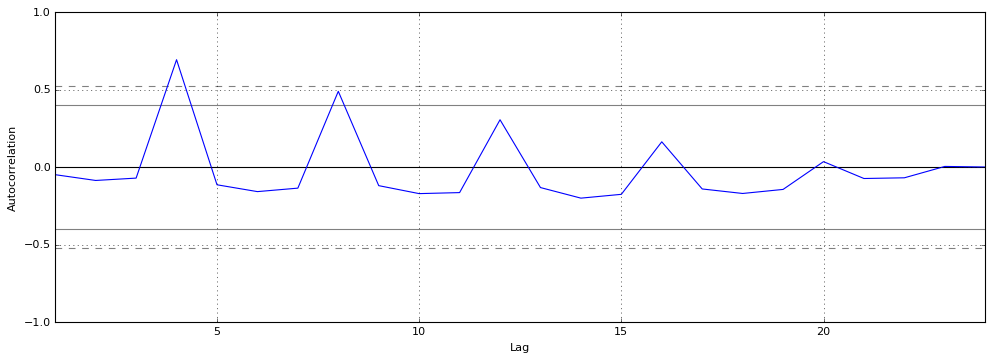

In [8]:
plt.figure(figsize=(15, 5))
autocorrelation_plot(aust['Sales']);

# Here we run three variants of triple exponential smoothing:

> We want to match the results from [7.5 Holt-Winters seasonal method](https://www.otexts.org/fpp/7/5)

* fit3a additive trend, additive seasonal of period season_length=4 and the use of a Boxcox transformation.
* fit3b additive trend, multiplicative seasonal of period season_length=4 and the use of a Boxcox transformation..
* fit3c additive damped trend, additive seasonal of period season_length=4 and the use of a boxcox transformation.
* fit3d additive damped trend, multiplicative seasonal of period season_length=4 and the use of a boxcox transformation.
The plot shows the results and forecast for fit1 and fit2. The table allows us to compare the results and parameterizations.

> Notice the commented out lines of code below. They use boxcox.

> What is ***boxcox***?  
* It is a transformation on your data to deal with the problem that the variance keeps changing over time. If you look at the first chart you will notice that every quarter the variance seems to increase over time. The boxcox transformaition attempts to make the variance on our data constant and it might help us get better results.  
* [reference](https://datascienceplus.com/time-series-analysis-in-r-part-2-time-series-transformations)
* [another reference](https://machinelearningmastery.com/power-transform-time-series-forecast-data-python)

In [9]:
fit3a = ExponentialSmoothing(aust['Sales'], seasonal_periods=4, trend='add', seasonal='add').fit()
fit3b = ExponentialSmoothing(aust['Sales'], seasonal_periods=4, trend='add', seasonal='mul').fit()
fit3c = ExponentialSmoothing(aust['Sales'], seasonal_periods=4, trend='add', seasonal='add', damped=True).fit()
fit3d = ExponentialSmoothing(aust['Sales'], seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit()

#fit3a = ExponentialSmoothing(aust['Sales'], seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
#fit3b = ExponentialSmoothing(aust['Sales'], seasonal_periods=4, trend='add', seasonal='mul').fit(use_boxcox=True)
#fit3c = ExponentialSmoothing(aust['Sales'], seasonal_periods=4, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
#fit3d = ExponentialSmoothing(aust['Sales'], seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

The number (8) in the code below is how far in the future we want to make a forecast. The number three was chosen to match the text.  

> note: The ***forecast*** method is what you will use to make future predictions

In [10]:
# rename the pandas object for plotting
fcast3a = fit3a.forecast(8).rename(r'TriExp_add')
fcast3b = fit3b.forecast(8).rename(r'TriExp_mul')

# you will find the Holt-Winters damped method at the bottom of the website
fcast3c = fit3c.forecast(8).rename(r'TriExp_add_damp')
fcast3d = fit3d.forecast(8).rename(r'TriExp_mul_damp')

***fittedvalues*** - The data under fittedvalues contains the predictions.

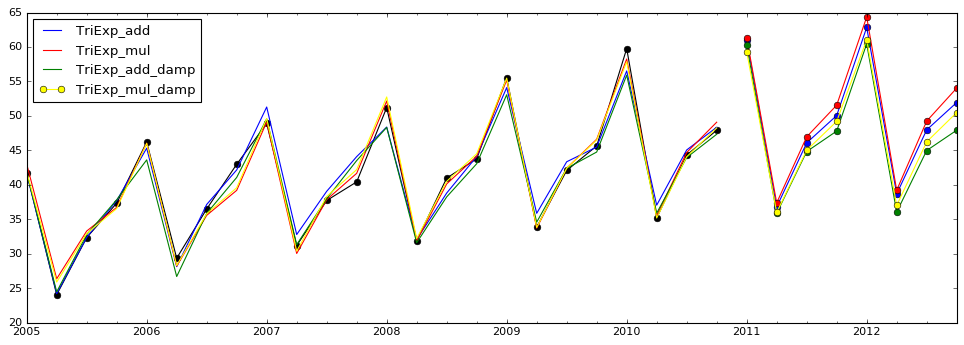

In [11]:
ax = aust['Sales'].plot(color="black", marker="o", figsize=(15,5))

fit3a.fittedvalues.plot(ax=ax, color='blue')
fcast3a.plot(ax=ax, color='blue', marker="o", legend=True)

fit3b.fittedvalues.plot(ax=ax, color='red')
fcast3b.plot(ax=ax, color='red', marker="o", legend=True)

fit3c.fittedvalues.plot(ax=ax, color='green')
fcast3c.plot(ax=ax, color='green', marker="o", legend=True)

fit3d.fittedvalues.plot(ax=ax, color='yellow')
fcast3d.plot(ax=ax, color='yellow', marker="o", legend=True);

### Add the predictions to your original dataframe

In [12]:
# we add the predictions
aust['fit3a'] = fit3a.fittedvalues
aust['fit3b'] = fit3b.fittedvalues
aust['fit3c'] = fit3c.fittedvalues
aust['fit3d'] = fit3d.fittedvalues

# the future predictions get added this way
aust = pd.concat([aust, fcast3a.rename('fcast3a')], axis=1)
aust = pd.concat([aust, fcast3b.rename('fcast3b')], axis=1)
aust = pd.concat([aust, fcast3c.rename('fcast3c')], axis=1)
aust = pd.concat([aust, fcast3d.rename('fcast3d')], axis=1)

# make sure the table matches Tables in section 7.5
# note: The numbers were close but I could not get them to match exactly
aust

Sales      fit3a      fit3b      fit3c      fit3d    fcast3a  \
2005-03-01  41.7275  41.643985  43.005262  41.758411  41.882672        NaN   
2005-06-01  24.0418  24.189823  26.352815  24.460054  25.874647        NaN   
2005-09-01  32.3281  32.361914  33.284534  32.759302  32.909006        NaN   
2005-12-01  37.3287  37.698744  36.719478  37.828389  36.543984        NaN   
2006-03-01  46.2132  45.318444  46.055752  43.612466  46.012326        NaN   
2006-06-01  29.3463  28.113598  28.189526  26.678568  28.277477        NaN   
2006-09-01  36.4829  37.143236  35.564637  35.848094  35.791524        NaN   
2006-12-01  42.9777  42.155317  39.192534  41.064695  39.567206        NaN   
2007-03-01  48.9015  51.288383  49.106242  49.560883  49.612044        NaN   
2007-06-01  31.1802  32.776529  30.026239  31.307509  30.371965        NaN   
2007-09-01  37.7179  39.053312  37.844740  37.987705  38.304144        NaN   
2007-12-01  40.4202  44.091576  41.665591  43.517502  42.202475        NaN   
2008-03-01  51.2069  48.378858  52.156733  48.335326  52.749831        NaN   
2008-06-01  31.8872  32.060354  31.862951  31.595231  32.197680        NaN   
2008-09-01  40.9783  38.800782  40.124844  38.241976  40.494334        NaN   
2008-12-01  43.7725  44.107278  44.138646  43.054671  44.499575        NaN   
2009-03-01  55.5586  54.110424  55.207223  53.070461  55.484963        NaN   
2009-06-01  33.8509  35.853374  33.699664  34.573312  33.789111        NaN   
2009-09-01  42.0764  43.341510  42.404947  42.386754  42.403469        NaN   
2009-12-01  45.6423  45.481444  46.611702  44.755189  46.501901        NaN   
2010-03-01  59.7668  56.523374  58.257713  55.914390  57.869112        NaN   
2010-06-01  35.1919  37.041135  35.536376  35.880746  35.176322        NaN   
2010-09-01  44.3197  45.056024  44.685050  43.957695  44.067615        NaN   
2010-12-01  47.9137  48.343948  49.084757  47.332210  48.247280        NaN   
2011-03-01      NaN        NaN        NaN        NaN        NaN  60.949380   
2011-06-01      NaN        NaN        NaN        NaN        NaN  36.785546   
2011-09-01      NaN        NaN        NaN        NaN        NaN  46.081198   
2011-12-01      NaN        NaN        NaN        NaN        NaN  50.053009   
2012-03-01      NaN        NaN        NaN        NaN        NaN  62.839597   
2012-06-01      NaN        NaN        NaN        NaN        NaN  38.675763   
2012-09-01      NaN        NaN        NaN        NaN        NaN  47.971416   
2012-12-01      NaN        NaN        NaN        NaN        NaN  51.943226   

              fcast3b    fcast3c    fcast3d  
2005-03-01        NaN        NaN        NaN  
2005-06-01        NaN        NaN        NaN  
2005-09-01        NaN        NaN        NaN  
2005-12-01        NaN        NaN        NaN  
2006-03-01        NaN        NaN        NaN  
2006-06-01        NaN        NaN        NaN  
2006-09-01        NaN        NaN        NaN  
2006-12-01        NaN        NaN        NaN  
2007-03-01        NaN        NaN        NaN  
2007-06-01        NaN        NaN        NaN  
2007-09-01        NaN        NaN        NaN  
2007-12-01        NaN        NaN        NaN  
2008-03-01        NaN        NaN        NaN  
2008-06-01        NaN        NaN        NaN  
2008-09-01        NaN        NaN        NaN  
2008-12-01        NaN        NaN        NaN  
2009-03-01        NaN        NaN        NaN  
2009-06-01        NaN        NaN        NaN  
2009-09-01        NaN        NaN        NaN  
2009-12-01        NaN        NaN        NaN  
2010-03-01        NaN        NaN        NaN  
2010-06-01        NaN        NaN        NaN  
2010-09-01        NaN        NaN        NaN  
2010-12-01        NaN        NaN        NaN  
2011-03-01  61.308205  60.247021  59.299661  
2011-06-01  37.373088  35.867379  35.985838  
2011-09-01  46.965154  44.822613  45.010372  
2011-12-01  51.557812  47.795498  49.205266  
2012-03-01  64.358695  60.457733  61.050039  
2012-06-01  39.209801  36.044603  37.004291  
2012-09-01  4

> What were the errors for the three models?  

Statmodels calculates the SSE for us so that we can compare the three models and determine which one has the lowest SSE.

In [13]:
print('fit3a errors = ', fit3a.sse)
print('fit3b errors = ', fit3b.sse)
print('fit3c errors = ', fit3c.sse)
print('fit3d errors = ', fit3d.sse)

fit3a errors =  62.3889905157
fit3b errors =  34.5937232535
fit3c errors =  68.3864391431
fit3d errors =  30.1784505851


> additive trend, additive seasonal of period season_length=4

In [14]:
fit3a.model.params

{'damping_slope': nan,
 'initial_level': 48.71717364806242,
 'initial_seasons': array([ -8.04570543, -26.51772624, -19.24796422, -14.85742959]),
 'initial_slope': 0.97251629587750632,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.42105262767165169,
 'smoothing_seasonal': 0.57894736451375695,
 'smoothing_slope': 0.28945909199195868,
 'use_boxcox': False}

> additive trend, multiplicative seasonal of period season_length=4

In [15]:
fit3b.model.params

{'damping_slope': nan,
 'initial_level': 50.569219928516027,
 'initial_seasons': array([ 0.8353429 ,  0.50296323,  0.62438092,  0.67721873]),
 'initial_slope': 0.91294561709068434,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 3.9195125004527298e-09,
 'smoothing_seasonal': 4.356337898575428e-07,
 'smoothing_slope': 2.3672761384656771e-16,
 'use_boxcox': False}

> fit3c additive damped trend, additive seasonal of period season_length=4

In [16]:
fit3c.model.params

{'damping_slope': 0.8410684252014432,
 'initial_level': 49.383295141752562,
 'initial_seasons': array([ -8.53930645, -26.59491937, -18.78200449, -14.08645262]),
 'initial_slope': 0.76909184224366689,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.36842104854721219,
 'smoothing_seasonal': 0.63157894328405428,
 'smoothing_slope': 0.046726023622302451,
 'use_boxcox': False}

> fit3d additive damped trend, multiplicative seasonal of period season_length=4

In [17]:
fit3d.model.params

{'damping_slope': 0.96624826174093537,
 'initial_level': 50.554330722488501,
 'initial_seasons': array([ 0.80623268,  0.48549092,  0.6027556 ,  0.65426039]),
 'initial_slope': 1.3472253158196399,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 6.8217588652866192e-10,
 'smoothing_seasonal': 2.7584604859758073e-13,
 'smoothing_slope': 1.804108226959745e-12,
 'use_boxcox': False}

# Residuals

The *residuals* in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values. Residuals are useful in checking whether a model has adequately captured the information in the data. 

### A good forecasting method will yield residuals with the following properties:

* The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

* The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: 

* If the residuals have mean m, then simply add m to all forecasts and the bias problem is solved. 
* Fixing the correlation problem is harder, and we will not address it until [Chapter 9](https://www.otexts.org/fpp/9).

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

* The residuals have constant variance
* The residuals are normally distributed  

These two properties make the calculation of prediction intervals easier (see Section 3.5 for an example). However, a forecasting method that does not satisfy these properties cannot necessarily be improved. Sometimes applying a Box-Cox transformation may assist with these properties, but otherwise there is usually little that you can do to ensure that your residuals have constant variance and a normal distribution. Instead, an alternative approach to obtaining prediction intervals is necessary. Again, we will not address how to do this until later in the book.

> We will use fit3d to calculate the residual as this gave us the best fit

In [18]:
# we remove null values to prevent any issues
res = aust['Sales'].dropna() - aust['fit3d'].dropna()

We can see that the variance does not seem constant at the end of year 2006 and 2010. We can also see from the bottom two charts that the data is not normal. This just means we will not be able to create confidence bands. The lag plot shows the residuals are uncorrelated or random.  

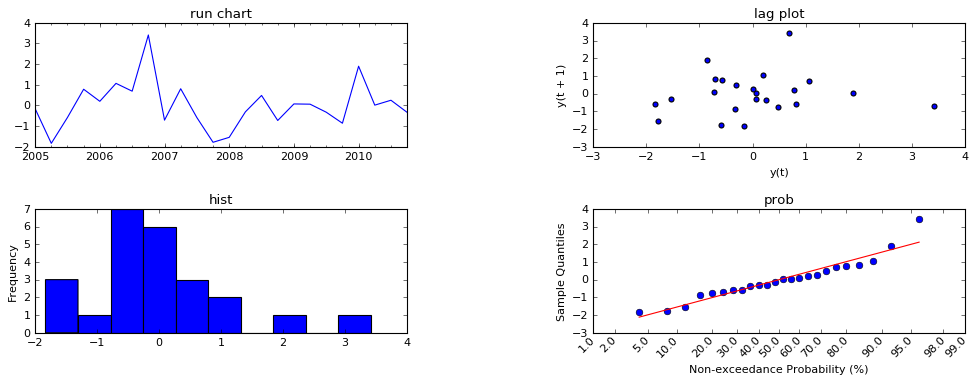

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.5, hspace=0.5);

res.plot(ax=axes[0,0], figsize=(15,5)); axes[0,0].set_title('run chart');
lag_plot(res, ax=axes[0,1]); axes[0,1].set_title('lag plot');
res.plot.hist(ax=axes[1,0], figsize=(15,5)); axes[1,0].set_title('hist');
sm.ProbPlot(res).probplot(line='r',ax=axes[1,1]); axes[1,1].set_title('prob');

> The ACP confirms that the residuals have no other hidden patterns we can make use of  

Since our ac plot is within the confidence bands our model has no other patterns in the data to work with. While this does not mean you cannot improve the model, it does mean your model should give you good results. 

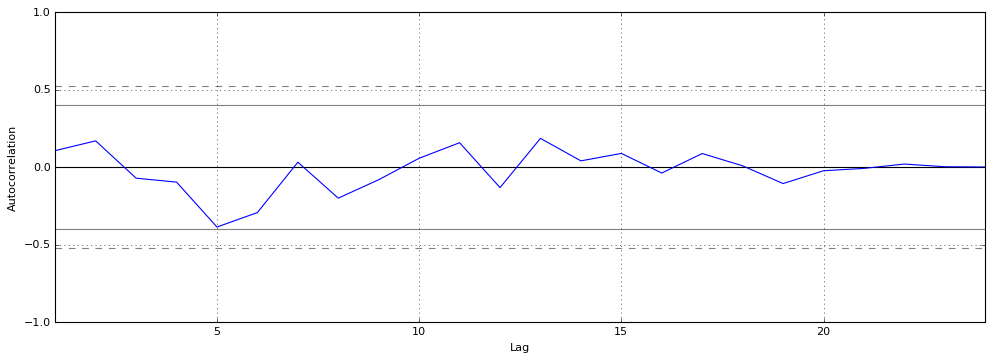

In [20]:
plt.figure(figsize=(15, 5))
autocorrelation_plot(res);

> The mean and the median both are close to zero. This confirms our predictions are not biased.

If a biased existed, you would simply add the amount of the median to all of your predictions. 

In [21]:
res.describe()

count    24.000000
mean      0.000022
std       1.145472
min      -1.832847
25%      -0.617319
50%      -0.069797
75%       0.535819
max       3.410494
dtype: float64

> Some code to get Statsmodels to identify the time series components automatically for you. This can be useful to verify if your data has seasonality or a trend.

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(aust['Sales'].dropna())

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(wspace=0.5, hspace=0.5);

trend.plot(ax=axes[0], figsize=(15,10)); axes[0].set_title('trend');
seasonal.plot(ax=axes[1], figsize=(15,10)); axes[1].set_title('season');
residual.plot(ax=axes[2], figsize=(15,10)); axes[2].set_title('residual');

> We can also get this information from our model

In [24]:
pieces = pd.concat([fit3d.level.rename('level'), fit3d.resid.rename('residual'), fit3d.season.rename('season')], axis=1)
pieces

level  residual    season
2005-03-01  51.948616 -0.155172  0.806233
2005-06-01  53.295841 -1.832847  0.485491
2005-09-01  54.597595 -0.580906  0.602756
2005-12-01  55.855413  0.784716  0.654260
2006-03-01  57.070777  0.200874  0.806233
2006-06-01  58.245120  1.068823  0.485491
2006-09-01  59.379828  0.691376  0.602756
2006-12-01  60.476237  3.410494  0.654260
2007-03-01  61.535640 -0.710544  0.806233
2007-06-01  62.559286  0.808235  0.485491
2007-09-01  63.548383 -0.586244  0.602756
2007-12-01  64.504096 -1.782275  0.654260
2008-03-01  65.427552 -1.542931  0.806233
2008-06-01  66.319840 -0.310480  0.485491
2008-09-01  67.182011  0.483966  0.602756
2008-12-01  68.015083 -0.727075  0.654260
2009-03-01  68.820037  0.073637  0.806233
2009-06-01  69.597823  0.061789  0.485491
2009-09-01  70.349357 -0.327069  0.602756
2009-12-01  71.075525 -0.859601  0.654260
2010-03-01  71.777184  1.897688  0.806233
2010-06-01  72.455161  0.015578  0.485491
2010-09-01  73.110254  0.252085  0.602756
2010-12-01  73.743238 -0.333580  0.654260

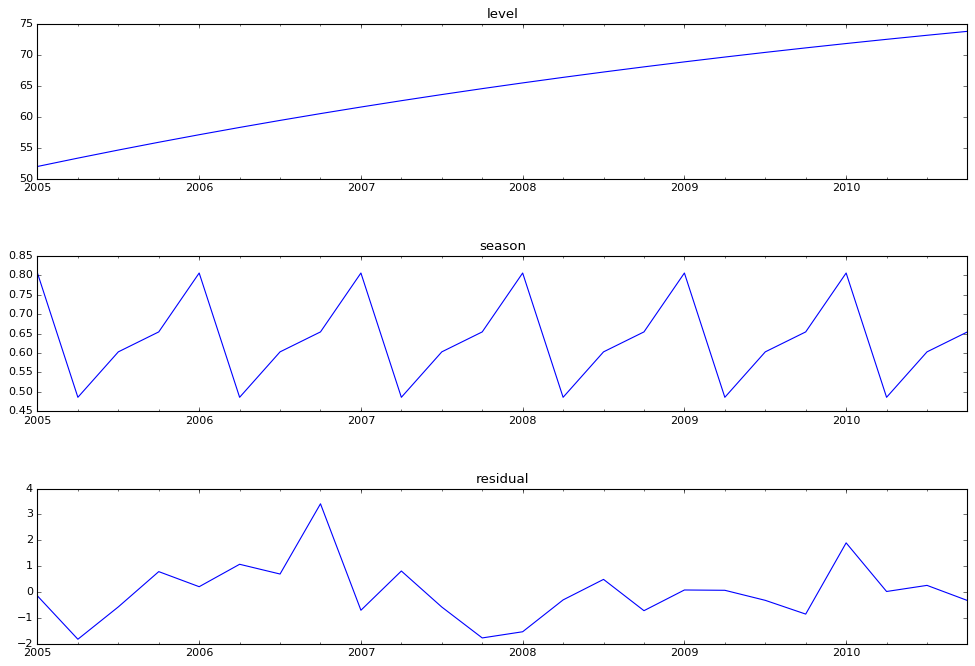

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(wspace=0.5, hspace=0.5);

pieces['level'].plot(ax=axes[0], figsize=(15,10)); axes[0].set_title('level');
pieces['season'].plot(ax=axes[1], figsize=(15,10)); axes[1].set_title('season');
pieces['residual'].plot(ax=axes[2], figsize=(15,10)); axes[2].set_title('residual');

<p class="text-muted">This tutorial was created by <a href="http://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>